In [24]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
#common functions
def load_dataframe(name):
    df = pd.read_csv(f'./stocks/{name}.csv') # Default load local csv file
    return df

def get_df_from_year(df, from_year=None, to_year=None):
    if from_year == None:
        from_year = int(df.iloc[0,0].split('-')[0])
    if to_year == None:
        to_year = int(df.iloc[len(df)-1,0].split('-')[0])
    return df[(df["Date"] >= f'{from_year}-01-01') & (df["Date"] < f'{to_year+1}-01-01')]
    
def get_X_train(df, **kwargs):
    start_index = kwargs['start_index']
    end_index = kwargs['end_index']
    day_before = kwargs["day_before"]
    X_train = df.iloc[start_index:end_index, 1:2].values
    X_train = sc.fit_transform(X_train)
    X_train = [X_train[i-day_before:i, 0] for i in range(day_before, len(X_train))]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train

def get_y_train(df, **kwargs):
    start_index = kwargs['start_index']
    end_index = kwargs['end_index']
    day_before = kwargs["day_before"]
    y_train = df.iloc[start_index:end_index, 1:2].values
    y_train = sc.fit_transform(y_train)[0+day_before:end_index]
    return y_train
    
def get_X_test():
    return 1
def get_y_test():
    return 1

X_train = get_X_train(df, start_index=0, end_index=800, day_before=60)
y_train = get_y_train(df, start_index=0, end_index=800, day_before=60)
print(X_train.shape)
print(y_train.shape)

In [176]:
stock_name = "AAPL"

In [177]:
df = load_dataframe(stock_name)
df = get_df_from_year(df)
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1684, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.059309,115127600
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.029022,84472400
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.166470,88774400
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.469334,127007600
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,27.720942,134247600


In [178]:
#splitin train set & train set
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

sc = MinMaxScaler(feature_range = (0, 1))

In [179]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
print(y_train)
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

[0.1358763359362306, 0.1336268670600287, 0.13357904471594007, 0.13137741732807984, 0.1360198986897616, 0.13635488482941815, 0.13367470854837038, 0.13305257775739898, 0.12989375686189852, 0.12348045123846763, 0.12496411170464883, 0.12290606621457256, 0.12257108007491602, 0.12482052980686498, 0.12166170891136452, 0.1275007252321656, 0.1325739331429463, 0.13453623822358018, 0.13721641450462796, 0.13458407971192188, 0.13539769132177804, 0.14023167264659753, 0.1519095904226816, 0.14257678621097658, 0.14702786333078566, 0.14817648022455143, 0.15904086296779152, 0.18220538999935232, 0.18105677310558677, 0.17540918017091112, 0.18617782250470882, 0.19244756537460894, 0.19211257923495229, 0.18091321035205576, 0.16976166381324764, 0.1798602572907203, 0.1828275973673359, 0.18713501601234894, 0.18206180810156847, 0.18153534114302716, 0.1828275973673359, 0.18005168067684574, 0.18268401546955193, 0.1788551648619794, 0.18081745079836042, 0.18445483973130128, 0.18234895275288332, 0.187709401036244, 0.1

In [189]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 7s 52ms/step - loss: 0.0378
Epoch 2/100
24/24 [==============================] - 1s 54ms/step - loss: 0.0069
Epoch 3/100
24/24 [==============================] - 1s 49ms/step - loss: 0.0054
Epoch 4/100
24/24 [==============================] - 1s 48ms/step - loss: 0.0053
Epoch 5/100
24/24 [==============================] - 1s 50ms/step - loss: 0.0052
Epoch 6/100
24/24 [==============================] - 1s 48ms/step - loss: 0.0047
Epoch 7/100
24/24 [==============================] - 1s 50ms/step - loss: 0.0047
Epoch 8/100
24/24 [==============================] - 1s 50ms/step - loss: 0.0054
Epoch 9/100
24/24 [==============================] - 1s 49ms/step - loss: 0.0056
Epoch 10/100
24/24 [==============================] - 1s 48ms/step - loss: 0.0038
Epoch 11/100
24/24 [==============================] - 1s 48ms/step - loss: 0.0038
Epoch 12/100
24/24 [==============================] - 1s 48ms/step - loss: 0.0033
Epoch 13/100
24/24 [=====

In [190]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
print(inputs)
inputs = sc.transform(inputs)
print(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
print()
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# (459, 60, 1)

[[ 67.202499]
 [ 66.945   ]
 [ 67.864998]
 [ 69.25    ]
 [ 69.892502]
 [ 69.949997]
 [ 69.875   ]
 [ 70.557503]
 [ 70.1325  ]
 [ 71.172501]
 [ 71.205002]
 [ 72.779999]
 [ 72.364998]
 [ 72.482498]
 [ 74.059998]
 [ 74.287498]
 [ 73.447502]
 [ 74.959999]
 [ 74.290001]
 [ 76.809998]
 [ 77.650002]
 [ 77.910004]
 [ 79.175003]
 [ 77.962502]
 [ 78.397499]
 [ 79.067497]
 [ 79.297501]
 [ 79.644997]
 [ 79.480003]
 [ 80.0625  ]
 [ 77.514999]
 [ 78.150002]
 [ 81.112503]
 [ 80.135002]
 [ 80.232498]
 [ 76.074997]
 [ 78.827499]
 [ 80.879997]
 [ 80.642502]
 [ 80.592499]
 [ 78.544998]
 [ 80.900002]
 [ 80.3675  ]
 [ 81.047501]
 [ 81.184998]
 [ 78.839996]
 [ 80.      ]
 [ 80.657501]
 [ 79.654999]
 [ 74.315002]
 [ 75.237503]
 [ 71.6325  ]
 [ 70.275002]
 [ 64.315002]
 [ 70.57    ]
 [ 75.917503]
 [ 74.110001]
 [ 73.879997]
 [ 70.5     ]
 [ 65.9375  ]
 [ 69.285004]
 [ 69.347504]
 [ 63.985001]
 [ 66.222504]
 [ 60.487499]
 [ 61.877499]
 [ 59.942501]
 [ 61.8475  ]
 [ 61.794998]
 [ 57.02    ]
 [ 59.09    ]
 [ 62.

[[0.7323155 ]
 [0.72738588]
 [0.74499855]
 [0.77151338]
 [0.7838136 ]
 [0.7849143 ]
 [0.78347854]
 [0.79654455]
 [0.78840818]
 [0.80831822]
 [0.80894043]
 [0.83909257]
 [0.83114769]
 [0.83339714]
 [0.8635972 ]
 [0.86795251]
 [0.85187142]
 [0.88082704]
 [0.86800043]
 [0.91624389]
 [0.93232514]
 [0.93730269]
 [0.96152015]
 [0.93830772]
 [0.94663541]
 [0.95946203]
 [0.96386528]
 [0.97051783]
 [0.96735914]
 [0.97851061]
 [0.92974061]
 [0.94189727]
 [0.99861214]
 [0.97989861]
 [0.9817651 ]
 [0.90217285]
 [0.95486744]
 [0.99416098]
 [0.98961432]
 [0.98865705]
 [0.94945917]
 [0.99454396]
 [0.98434961]
 [0.99736772]
 [1.        ]
 [0.95510669]
 [0.9773141 ]
 [0.98990146]
 [0.97070931]
 [0.86847906]
 [0.88613965]
 [0.81712456]
 [0.79113628]
 [0.67703653]
 [0.79678379]
 [0.89915774]
 [0.86455447]
 [0.86015121]
 [0.79544369]
 [0.70809804]
 [0.7721835 ]
 [0.77338002]
 [0.67071891]
 [0.71355423]
 [0.60376184]
 [0.63037235]
 [0.59332826]
 [0.62979805]
 [0.62879293]
 [0.53737916]
 [0.57700777]
 [0.64

In [191]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

15/15 [==============================] - 1s 18ms/step


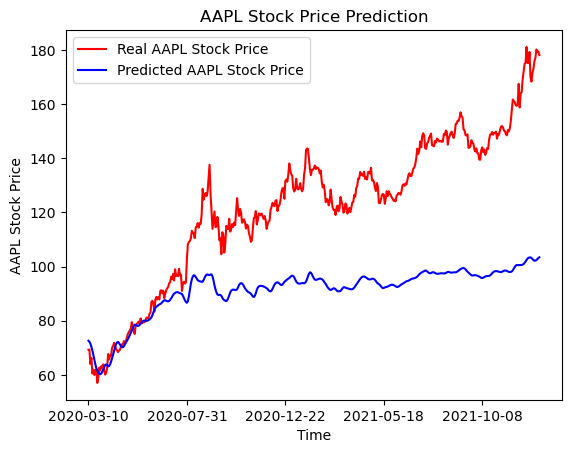

In [192]:
# Visualising the results
plt.plot(df.loc[800:800+predicted_stock_price.shape[0]-1, "Date"], dataset_test[0:459].values, color = "red", label = f'Real {stock_name} Stock Price')
plt.plot(df.loc[800:800+predicted_stock_price.shape[0]-1, "Date"], predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
plt.xticks(np.arange(0,459,100))
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_name} Stock Price')
plt.legend()
plt.show()

In [ ]:


def split_train_test_set(df, day_before=60):
    X_train, X_test, y_train, y_test = train_test_split(
        df.iloc[0:, 1:2].values, #Retrieve column "Open"
        df.iloc[0:, 1:2].values,
        test_size=0.8,
        shuffle=False
    )
    sc = MinMaxScaler(feature_range = (0, 1))
    X_train = sc.fit_transform(X_train)
    y_train = y_train[day_before:]
    X_train = [X_train[i-day_before:i, 0] for i in range(day_before, len(X_train))]
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #X_test = df.iloc[X_train-day_before:]
    X_test = X_test.reshape(-1,1)
    X_test = sc.transform(X_test)
    X_test = [X_test[i-day_before:i, 0] for i in range(day_before, len(X_test))]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print("X_train shape: ", X_train.shape)
    print("y_train shape: ", y_train.shape)
    print(X_train)
    return X_train, X_test, y_train, y_test

#df = load_dataframe("TSLA")
#X_train, X_test, y_train, y_test = split_train_test_set(df)

#predicted_stock_price = model.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#predicted_stock_price.shape

In [ ]:
# Visualising the results
plt.plot(df.loc[X_train.shape[0]+60:, "Date"], df.loc[X_train.shape[0]+60:, "Open"], color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[X_train.shape[0]+60:, "Date"], predicted_stock_price, color = "blue", label = "Real TESLA Stock Price")
plt.xticks(np.arange(0,459,600))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

(740, 60, 1)
(740, 1)
